In [1]:
#Include the UNSflow libraries
#Pkg.clone("git://github.com/KiranUofG/UNSflow")
include("../src/UNSflow.jl")
using UNSflow

#### This notebook shows how to obtain static constants $\alpha_1$, S1, S2 basing on data from Xfoil. Table of static constants for different aerofoils can be found in notebook 1.2.

Input: CL($\alpha$), CD($\alpha$) characteristics from Xfoil

Output: Static constants $\alpha_1$, S1, S2; prediction of separation point position f_model

There are various methods to obtain aforementioned static constants. More information acan be found in publications:
1. W. Sheng, R. A. M. Galbraith, and F. N. Coton, “A Modified Dynamic Stall Model for Low Mach Numbers,” Journal of Solar Energy Engineering, vol. 130, no. 3, p. 031013, 2008.
2. E. Dyachuk, A. Goude, and H. Bernhoff, “Dynamic Stall Modeling for the Conditions of Vertical Axis Wind Turbines,” AIAA Journal, vol. 52, no. 1, pp. 72–81, 2014.
3. O. A. Bauchau, “DYMORE user’s manual,” Georgia Institute of Technology, Atlanta, 2007.

In [2]:
#Read CN(alpha) data from file prepared in xfoil
xfoil = Xfoil("sd7003_data.txt")

#Calculate f basing on CN(alpha)
f = fFromCN(xfoil.alpha, xfoil.CN)

#Obtain static coefficients
#Two models are available, Sheng and Original
alpha1Sh, s1Sh, s2Sh, f_modelSh = findStaticCoeff(xfoil.alpha, f, "Sheng") 
alpha1Or, s1Or, s2Or, f_modelOr = findStaticCoeff(xfoil.alpha, f, "Original");


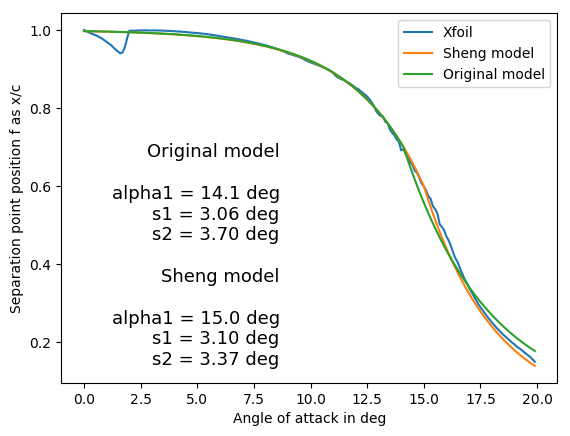

PyObject <matplotlib.text.Annotation object at 0x000000001D6A2FD0>

In [3]:
plot(xfoil.alpha, f, label="Xfoil")
plot(xfoil.alpha, f_modelSh, label="Sheng model")
plot(xfoil.alpha, f_modelOr, label="Original model")
legend()
xlabel("Angle of attack in deg")
ylabel("Separation point position f as x/c")
annot = string("Original model\n", "\nalpha1 = ", string(alpha1Or)[1:4], " deg\ns1 = ", string(s1Or)[1:4], " deg\ns2 = ", string(s2Or)[1:4], " deg\n\n", "Sheng model\n", "\nalpha1 = ", string(alpha1Sh)[1:4], " deg\ns1 = ", string(s1Sh)[1:4], " deg\ns2 = ", string(s2Sh)[1:4], " deg")
            annotate(annot,
            xy=[1;0],
            xycoords="axes fraction",
            xytext=[-200,10],
            textcoords="offset points",
            fontsize=13.0,
            ha="right",
            va="bottom")

### It should be noted that alpha1 can be approximated as the stall angle. 

### Procedures implemented in functions fFromCN and findStaticCoeff are now explained step by step.

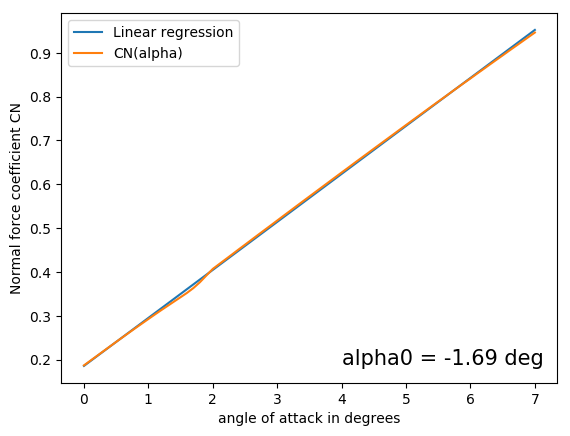

PyObject <matplotlib.text.Annotation object at 0x0000000024012BA8>

In [14]:
#Read data exported from xfoil. For instructions how to export data from xfoil, see report.
xfoil_file = "sd7003_data.txt"
data = readdlm(xfoil_file; skipstart = 12) 
alpha = data[:,1]
CL = data[:,2]
CD = data[:,3]
CM = data[:,5]

#Calculate normal force coefficient CL basing on CN and CD
CN = zeros(length(alpha))

    for idx = 1 : length(alpha)
        CN[idx] = CL[idx]*cos(deg2rad(alpha[idx]))+CD[idx]*sin(deg2rad(alpha[idx]))
    end

##Extract airfoil's name
nline = open(readlines, "sd7003_data.txt")[4]
id = search(nline,":")[1]

#STEP 1: FIND ALPHA_0 FROM LINEAR PART OF CN

    lin = 7 #angle in degrees at which CN is still linear, modify if neccessary

    #trim domain to linear part
    idx_linear = 1
    while(alpha[idx_linear]<7)
        idx_linear+=1
    end
    
    #find b,a for y = bx + a
    a,b = linreg(alpha[1:idx_linear], CN[1:idx_linear])
    alpha0 = -a/b

    #confirm that only linear part of CN was used
    plot(alpha[1:idx_linear],b*alpha[1:idx_linear]+a, label ="Linear regression")
    plot(alpha[1:idx_linear],CN[1:idx_linear], label= "CN(alpha)")
    legend()
    xlabel("angle of attack in degrees")
    ylabel("Normal force coefficient CN")
            annotate("alpha0 = "string(alpha0)[1:5]" deg",
            xy=[1;0],
            xycoords="axes fraction",
            xytext=[-10,10],
            textcoords="offset points",
            fontsize=15.0,
            ha="right",
            va="bottom")

#### Alpha0 is the angle at which CN = 0

#### In the next step, separation point f will be calculated from static data using the formula:
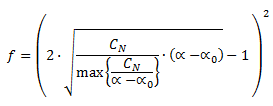

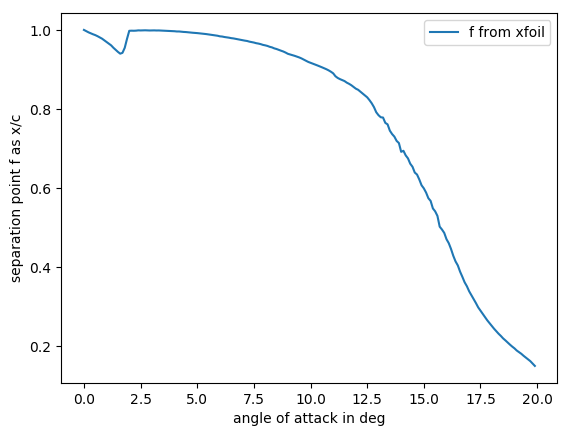

PyObject <matplotlib.legend.Legend object at 0x00000000291A0978>

In [16]:
#Calculate max. slope from static data, amax, to guarantee that f will not exceed 1
    amax = 0
    for idx = 1 : idx_linear
        if(CN[idx]/(alpha[idx]-alpha0) > amax)
        amax = CN[idx]/(alpha[idx]-alpha0)
        end
    end

#STEP 2: DETERMINE F FROM STATIC DATA
f = zeros(length(alpha))

for idx = 1 : length(alpha)
    f[idx] = (2*sqrt(CN[idx]/(amax*(alpha[idx]-alpha0)))-1)^2
end 


plot(alpha,f, label="f from xfoil")
xlabel("angle of attack in deg")
ylabel("separation point f as x/c")
legend()
#title(foil_no)

#### Now, a model is required to obtain continuous f(alpha) function from discrete points.
#### For Sheng model, piecewise function is defined as:
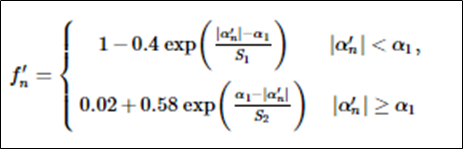
#### where  $\alpha_1$ is the angle of attack at which f = 0.6. Optimization is performed to obtain static constants S1, S2.

In [17]:
fsep =  0.6

temp = abs(f.-fsep)
idxf = findfirst(temp,minimum(temp))

alpha1 = alpha[idxf]

15.0

In [18]:
#STEP 3: OPTIMIZE 

pcws1(x, s1) = 1.0.-0.4.*exp((abs(x).-alpha1)./s1)
pcws2(x, s2) = 0.02.+0.58.*exp((alpha1.-abs(x))./s2)

s1_0 = [3.5]
s2_0 = [3.5]

alpha_pcws1 = alpha[1:idxf]
alpha_pcws2 = alpha[idxf:end]

f_pcws1 = f[1:idxf]
f_pcws2 = f[idxf:end]

fit1 = curve_fit(pcws1, alpha_pcws1, f_pcws1, s1_0)
fit2 = curve_fit(pcws2, alpha_pcws2, f_pcws2, s2_0)

s1 = fit1.param
s2 = fit2.param

1-element Array{Float64,1}:
 3.37376

 at In[18]:3.


In [19]:
annot = string("alpha0 = ", string(alpha0)[1:5],"\nalpha1 = ", string(alpha1)[1:4], "\ns1 = ", string(s1)[2:5], "\ns2 = ", string(s2)[2:5])

"alpha0 = -1.69\nalpha1 = 15.0\ns1 = 3.10\ns2 = 3.37"

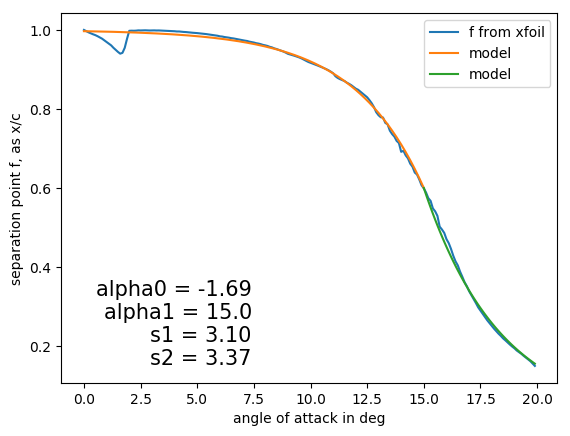

PyObject <matplotlib.text.Annotation object at 0x000000002949BCC0>

In [20]:
plot(alpha,f, label="f from xfoil")
plot(alpha_pcws1,pcws1(alpha_pcws1,fit1.param),label = "model")
plot(alpha_pcws2,pcws2(alpha_pcws2,fit2.param), label = "model")
legend()
#title(foil_no)
xlabel("angle of attack in deg")
ylabel("separation point f, as x/c")
            annotate(annot,
            xy=[1;0],
            xycoords="axes fraction",
            xytext=[-220,10],
            textcoords="offset points",
            fontsize=15.0,
            ha="right",
            va="bottom")